* Denoising Diffusion Probabilistic Models on MNIST dataset. 

## Import libraries


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
from IPython.display import Image
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def show_images(images, title=""):
    # Get number of images
    num_images = len(images)

    # Determine number of rows and columns needed for the subplots
    if num_images>8:
        num_rows = int(math.sqrt(num_images))
        num_cols = math.ceil(num_images / num_rows)
    else:
        num_rows = 1
        num_cols = num_images

    # Create figure and add subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    fig.suptitle(title, fontsize=20)

    # Display each image in its corresponding subplot
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(images[i].permute(1, 2, 0).numpy(), cmap="gray")
            ax.axis("off")

    # Show the figure
    plt.show()

## Dataset

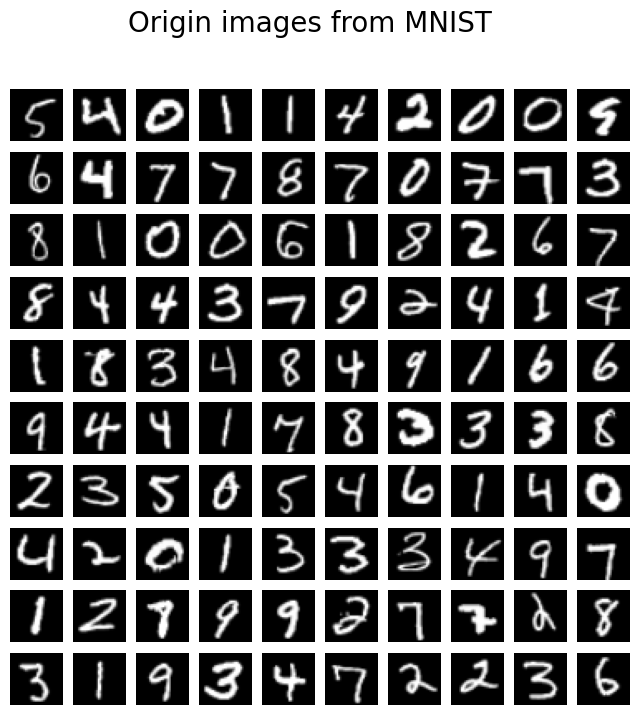

In [3]:
root_dir = "./data/"
transform01 = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
dataset = torchvision.datasets.MNIST(
    root='./dataset', train=True, transform=transform01, download=True
)
dataloader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=4096, shuffle=True, num_workers=10
)

for b in dataloader:
    batch = b[0]
    break

# select random images from the batch 
bn = [batch[i] for i in np.random.randint(0, batch.shape[0], 100)]
show_images(bn, "Origin images from MNIST") 

## Network architecture: UNet

In [4]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    positions = torch.arange(n).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2) * -(math.log(10000.0) / d))
    embeddings = torch.zeros(n, d)

    # Compute the sinusoidal embeddings
    embeddings[:, 0::2] = torch.sin(positions * div_term)
    embeddings[:, 1::2] = torch.cos(positions * div_term)

    return embeddings

class ConvNet(nn.Module):
    def __init__(
        self,
        input_shape,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super(ConvNet, self).__init__()
        self.layer_norm = nn.LayerNorm(input_shape)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.layer_norm(x) if self.normalize else x
        out = self.conv(out)
        out = self.activation(out)
        return out


def convolution_block(image_size, in_channels, out_channels):
    return nn.Sequential(
        ConvNet((in_channels, image_size, image_size), in_channels, out_channels),
        ConvNet((out_channels, image_size, image_size), out_channels, out_channels),
        ConvNet((out_channels, image_size, image_size), out_channels, out_channels),
    )


def tiny_upsampling_block(image_size, in_channels):
    return nn.Sequential(
        ConvNet((in_channels, image_size, image_size), in_channels, in_channels // 2),
        ConvNet((in_channels // 2, image_size, image_size), in_channels // 2, in_channels // 4),
        ConvNet((in_channels // 4, image_size, image_size), in_channels // 4, in_channels // 4),
    )

class TinyUNet(nn.Module):

    def _make_time_embedding_layer(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.SiLU(),
            nn.Linear(output_dim, output_dim)
        )

    def __init__(self, input_channels=1, output_channels=1, size=32, num_steps=1000, time_emb_dim=100):
        super(TinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embedding = nn.Embedding(num_steps, time_emb_dim)
        self.time_embedding.weight.data = sinusoidal_embedding(num_steps, time_emb_dim)
        self.time_embedding.requires_grad_(False)

        # First half
        self.time_embed_1 = self._make_time_embedding_layer(time_emb_dim, 1)
        self.conv_block_1 = convolution_block(size, input_channels, 10)
        self.downsampling_1 = nn.Conv2d(10, 10, kernel_size=4, stride=2, padding=1)
        self.time_embed_2 = self._make_time_embedding_layer(time_emb_dim, 10)
        self.conv_block_2 = convolution_block(size // 2, 10, 20)
        self.downsampling_2 = nn.Conv2d(20, 20, kernel_size=4, stride=2, padding=1)
        self.time_embed_3 = self._make_time_embedding_layer(time_emb_dim, 20)
        self.conv_block_3 = convolution_block(size // 4, 20, 40)
        self.downsampling_3 = nn.Conv2d(40, 40, kernel_size=4, stride=2, padding=1)

        # Bottleneck
        self.time_embed_mid = self._make_time_embedding_layer(time_emb_dim, 40)
        self.bottleneck = nn.Sequential(
            ConvNet((40, size // 8, size // 8), 40, 20),
            ConvNet((20, size // 8, size // 8), 20, 20),
            ConvNet((20, size // 8, size // 8), 20, 40),
        )

        # Second half
        self.upsampling_1 = nn.ConvTranspose2d(40, 40, kernel_size=4, stride=2, padding=1)
        self.time_embed_4 = self._make_time_embedding_layer(time_emb_dim, 80)
        self.upsampling_block_1 = tiny_upsampling_block(size // 4, 80)
        self.upsampling_2 = nn.ConvTranspose2d(20, 20, kernel_size=4, stride=2, padding=1)
        self.time_embed_5 = self._make_time_embedding_layer(time_emb_dim, 40)
        self.upsampling_block_2 = tiny_upsampling_block(size // 2, 40)
        self.upsampling_3 = nn.ConvTranspose2d(10, 10, kernel_size=4, stride=2, padding=1)
        self.time_embed_out = self._make_time_embedding_layer(time_emb_dim, 20)
        self.conv_block_out = convolution_block(size, 20, 10)
        self.output_convolution = nn.Conv2d(10, output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        # Apply time embedding to t
        t_embedded = self.time_embedding(t)
        
        # Pass input through first set of convolutions
        n = len(x)
        out1 = self.conv_block_1(x + self.time_embed_1(t_embedded).reshape(n, -1, 1, 1))
        out2 = self.conv_block_2(self.downsampling_1(out1) + self.time_embed_2(t_embedded).reshape(n, -1, 1, 1))
        out3 = self.conv_block_3(self.downsampling_2(out2) + self.time_embed_3(t_embedded).reshape(n, -1, 1, 1))

        # Pass through middle set of convolutions
        out_mid = self.bottleneck(self.downsampling_3(out3) + self.time_embed_mid(t_embedded).reshape(n, -1, 1, 1))

        # Pass through last set of convolutions, using skip connections to combine with previous layers
        out4 = torch.cat((out3, self.upsampling_1(out_mid)), dim=1)
        out4 = self.upsampling_block_1(out4 + self.time_embed_4(t_embedded).reshape(n, -1, 1, 1))
        out5 = torch.cat((out2, self.upsampling_2(out4)), dim=1)
        out5 = self.upsampling_block_2(out5 + self.time_embed_5(t_embedded).reshape(n, -1, 1, 1))
        out = torch.cat((out1, self.upsampling_3(out5)), dim=1)
        out = self.conv_block_out(out + self.time_embed_out(t_embedded).reshape(n, -1, 1, 1))
        out = self.output_convolution(out)
        return out

## Algorithm

**Forward Diffusion Process**

Given a schedule $\beta_1<\beta_2<\cdots<\beta_T$,
$$
\begin{aligned}
& q\left(x_t \mid x_{t-1}\right)=\mathcal{N}\left(x_t ; \sqrt{1-\beta_t} x_{t-1}, \beta_t I\right) \\
& q\left(x_{1: T} \mid x_0\right)=\prod_{t=1}^T q\left(x_t \mid x_{t-1}\right)
\end{aligned}
$$
We define $\alpha_t=1-\beta_t$ and $\overline{\alpha_t}=\prod_{i=1}^t \alpha_i$, then we have
$$
\begin{aligned}
x_t & =\sqrt{\alpha_t} x_{t-1}+\sqrt{1-\alpha_t} \epsilon_{t-1}, \text { with } \epsilon_{t-1} \sim \mathcal{N}(0, I) \\
& =\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\sqrt{\alpha_t\left(1-\alpha_{t-1}\right)} \epsilon_{t-2}+\sqrt{1-\alpha_t} \epsilon_{t-1} \\
& =\sqrt{\alpha_t \alpha_{t-1}} x_{t-2}+\sqrt{1-\alpha_t \alpha_{t-1}} \tilde{\epsilon}_t
\end{aligned}
$$
Hence, we have
$$
x_t=\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t} \epsilon
$$

**Sampling**

For sampling, we need to simulate the reversed diffusion (Markov chain) starting from $x_T \sim \mathcal{N}(0, I)$ and then:
$$
x_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta\left(x_t, t\right)\right)+\sqrt{\beta_t} \epsilon, \text { with } \epsilon \sim \mathcal{N}(0, I) \text {. }
$$


In [11]:
class DDPM(nn.Module):
    def __init__(
        self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device
    ) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(
            beta_start, beta_end, num_timesteps, dtype=torch.float32
        ).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device

    def add_noise(self, x_0, epsilon, t):
        # The forward process
        alpha_bar_t = self.alphas_cumprod[t].reshape(-1, 1, 1, 1)
        
        # Compute x_t
        
        x_t = (torch.sqrt(alpha_bar_t) * x_0) + torch.sqrt(1-alpha_bar_t) *  epsilon
        
        return x_t

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)

    def step(self, epsilon_theta, t, x_t):
        # one step of sampling (the reverse process)
        alpha_bar_t = self.alphas_cumprod[t].reshape(-1, 1, 1, 1)
        alpha_t = self.alphas[t].reshape(-1, 1, 1, 1) 
        beta_t = self.betas[t].reshape(-1, 1, 1, 1)
        
        
        pred_prev_sample = (1/(torch.sqrt(alpha_t))) * ( x_t - ( ( (1-alpha_t) / torch.sqrt(1-alpha_bar_t)) * epsilon_theta ) )
        #(x_t - torch.sqrt(1 - alpha_t) * epsilon_theta) / torch.sqrt(alpha_t)
        
        if t > 0:
            noise = torch.randn_like(epsilon_theta).to(self.device)
            
            # Compute final x_{t-1}
            # hint: based on beta_t and noise
            pred_prev_sample += torch.sqrt(beta_t) * noise

        return pred_prev_sample



In [12]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)
network = TinyUNet(input_channels=1, output_channels=1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
print(f"The number of trainable parameters in the model is {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

The number of trainable parameters in the model is 437532


**Approximating the reversed diffusion**

Note that the law $q\left(x_{t-1} \mid x_t, x_0\right)$ is explicit:
$$
q\left(x_{t-1} \mid x_t, x_0\right)=\mathcal{N}\left(x_{t-1} ; \mu\left(x_t, x_0\right), \gamma_t I\right),
$$
with
$$
\begin{aligned}
\mu\left(x_t, x_0\right) & =\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} x_t+\frac{\sqrt{\bar{\alpha}_{t-1} \beta_t}}{1-\bar{\alpha}_t} x_0 \\
\gamma_t & =\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t
\end{aligned}
$$
but we know that $x_0=1 / \sqrt{\bar{\alpha}_t}\left(x_t-\sqrt{1-\bar{\alpha}_t} \epsilon\right)$, hence we have
$$
\mu\left(x_t, x_0\right)=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon\right)=\mu\left(x_t, t\right),
$$
where we removed the dependence in $x_0$ and replace it with a dependence in $t$.
The idea is to approximate $q\left(x_{t-1} \mid x_t\right)$ by a neural network according to:
$$
p_\theta\left(x_{t-1} \mid x_t\right)=\mathcal{N}\left(x_{t-1} ; \mu_\theta\left(x_t, t\right), \beta_t I\right)
$$
and we approximate $q\left(x_{0: T}\right)$ by
$$
p\left(x_{0: T}\right)=p\left(x_T\right) \prod_{t=1}^T p_\theta\left(x_{t-1} \mid x_t\right),
$$
where $p\left(x_T\right) \sim \mathcal{N}(0, I)$. Note that the variance parameter is fixed to $\beta_t$ which is the forward variance (mainly for simplicity, variations have been proposed).
The neural network is trained by maximizing the usual Variational bound:
$$
\begin{aligned}
\mathbb{E}_{q\left(x_0\right)} \ln p_\theta\left(x_0\right) & \geq \mathbb{E}_{q\left(x_{0: T}\right)}\left[\ln \frac{q\left(x_{1: T} \mid x_0\right)}{p_\theta\left(x_{0: T}\right)}\right] \\
& =\mathbb{E}_q\left[\operatorname{KL}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)+\sum_{t=2}^T \operatorname{KL}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right)-\ln p_\theta\left(x_0 \mid x_1\right)\right] \\
& =L_T+\sum_{t=2}^T L_{t-1}+L_0
\end{aligned}
$$
Note that $L_T$ does not depend on $\theta$ and for the other terms, they correspond to a KL between Gaussian distributions with an explicit expression:
$$
L_{t-1}=\mathbb{E}_q\left[\frac{1}{2 \beta_t^2}\left\|\mu_\theta\left(x_t, t\right)-\mu\left(x_t, t\right)\right\|^2\right]
$$
Now, we make the change of variable:
$$
\mu_\theta\left(x_t, t\right)=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta\left(x_t, t\right)\right),
$$
so that we have
$$
\left\|\mu_\theta\left(x_t, t\right)-\mu\left(x_t, t\right)\right\|^2=\frac{\left(1-\alpha_t\right)^2}{1-\bar{\alpha}_t}\left\|\epsilon-\epsilon_\theta\left(\sqrt{\bar{\alpha}_t} x_0+\sqrt{1-\bar{\alpha}_t} \epsilon, t\right)\right\|^2
$$
Empirically, the prefactor is removed in the loss and instead of summing over all $t$, we average over a random $\tau \in[0, T-1]$, so that the loss is finally:
$$
\ell(\theta)=\mathbb{E}_\tau \mathbb{E}_\epsilon\left[\left\|\epsilon-\epsilon_\theta\left(\sqrt{\bar{\alpha}_\tau} x_0+\sqrt{1-\bar{\alpha}_\tau} \epsilon, \tau\right)\right\|^2\right]
$$


## Training model


Epoch 0:   0%|          | 0/15 [00:00<?, ?it/s]

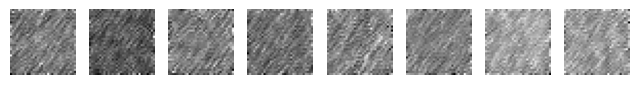

Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

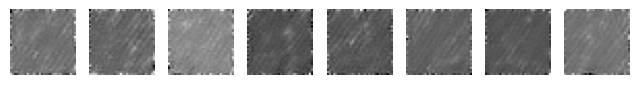

Epoch 2:   0%|          | 0/15 [00:00<?, ?it/s]

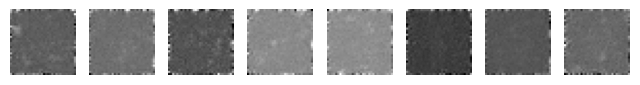

Epoch 3:   0%|          | 0/15 [00:00<?, ?it/s]

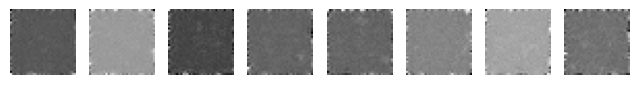

Epoch 4:   0%|          | 0/15 [00:00<?, ?it/s]

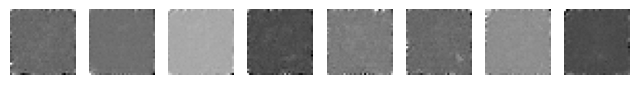

Epoch 5:   0%|          | 0/15 [00:00<?, ?it/s]

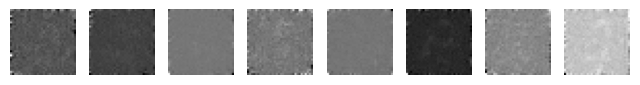

Epoch 6:   0%|          | 0/15 [00:00<?, ?it/s]

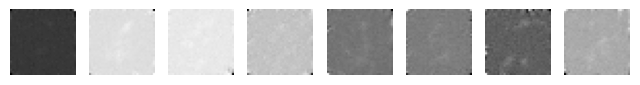

Epoch 7:   0%|          | 0/15 [00:00<?, ?it/s]

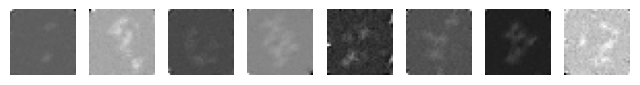

Epoch 8:   0%|          | 0/15 [00:00<?, ?it/s]

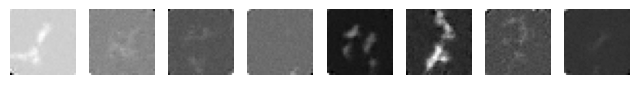

Epoch 9:   0%|          | 0/15 [00:00<?, ?it/s]

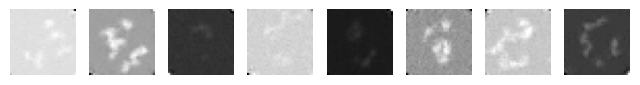

Epoch 10:   0%|          | 0/15 [00:00<?, ?it/s]

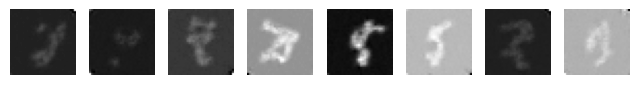

Epoch 11:   0%|          | 0/15 [00:00<?, ?it/s]

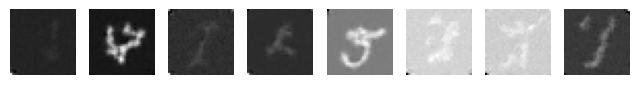

Epoch 12:   0%|          | 0/15 [00:00<?, ?it/s]

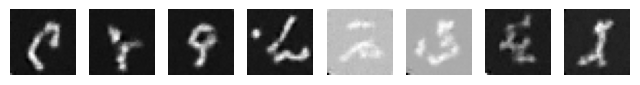

Epoch 13:   0%|          | 0/15 [00:00<?, ?it/s]

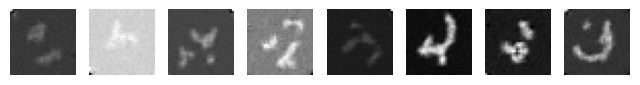

Epoch 14:   0%|          | 0/15 [00:00<?, ?it/s]

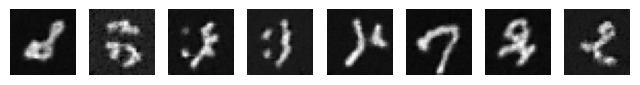

Epoch 15:   0%|          | 0/15 [00:00<?, ?it/s]

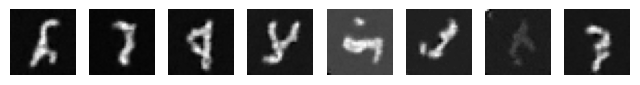

Epoch 16:   0%|          | 0/15 [00:00<?, ?it/s]

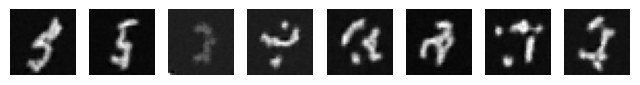

Epoch 17:   0%|          | 0/15 [00:00<?, ?it/s]

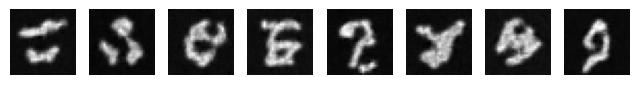

Epoch 18:   0%|          | 0/15 [00:00<?, ?it/s]

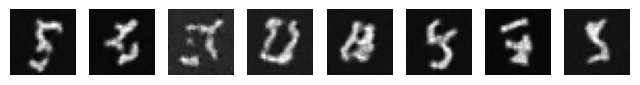

Epoch 19:   0%|          | 0/15 [00:00<?, ?it/s]

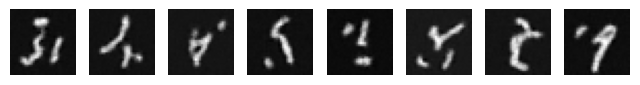

Epoch 20:   0%|          | 0/15 [00:00<?, ?it/s]

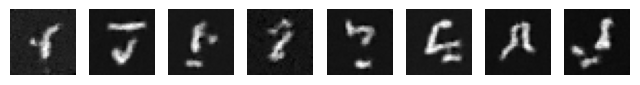

Epoch 21:   0%|          | 0/15 [00:00<?, ?it/s]

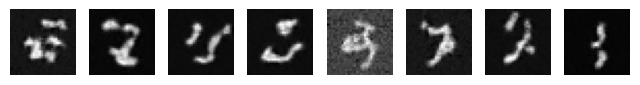

Epoch 22:   0%|          | 0/15 [00:00<?, ?it/s]

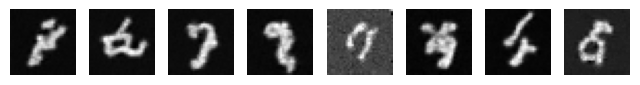

Epoch 23:   0%|          | 0/15 [00:00<?, ?it/s]

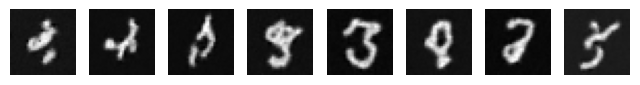

Epoch 24:   0%|          | 0/15 [00:00<?, ?it/s]

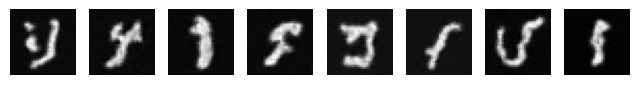

Epoch 25:   0%|          | 0/15 [00:00<?, ?it/s]

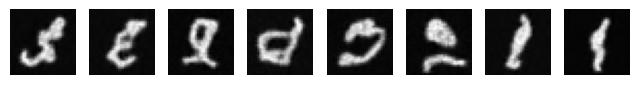

Epoch 26:   0%|          | 0/15 [00:00<?, ?it/s]

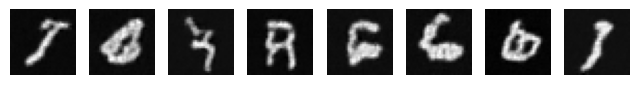

Epoch 27:   0%|          | 0/15 [00:00<?, ?it/s]

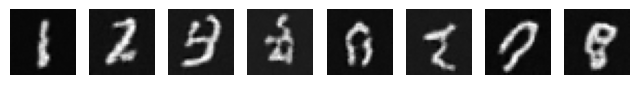

Epoch 28:   0%|          | 0/15 [00:00<?, ?it/s]

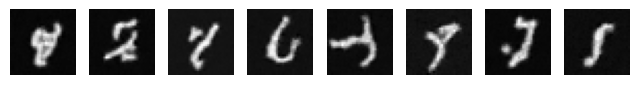

Epoch 29:   0%|          | 0/15 [00:00<?, ?it/s]

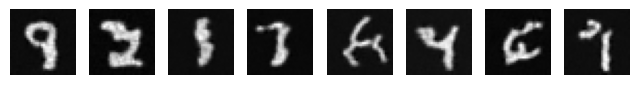

Epoch 30:   0%|          | 0/15 [00:00<?, ?it/s]

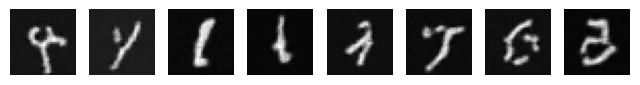

Epoch 31:   0%|          | 0/15 [00:00<?, ?it/s]

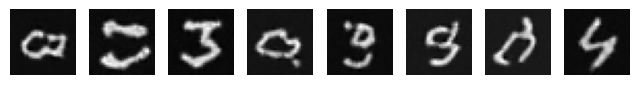

Epoch 32:   0%|          | 0/15 [00:00<?, ?it/s]

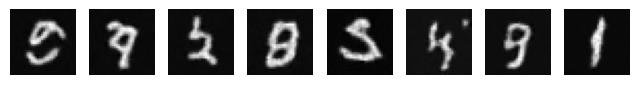

Epoch 33:   0%|          | 0/15 [00:00<?, ?it/s]

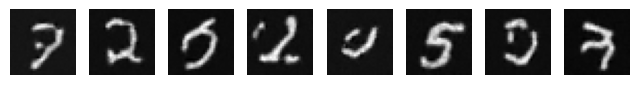

Epoch 34:   0%|          | 0/15 [00:00<?, ?it/s]

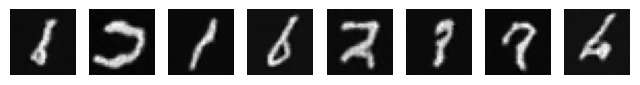

Epoch 35:   0%|          | 0/15 [00:00<?, ?it/s]

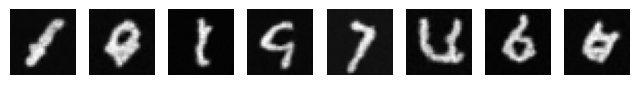

Epoch 36:   0%|          | 0/15 [00:00<?, ?it/s]

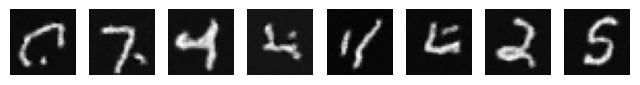

Epoch 37:   0%|          | 0/15 [00:00<?, ?it/s]

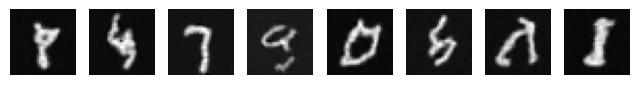

Epoch 38:   0%|          | 0/15 [00:00<?, ?it/s]

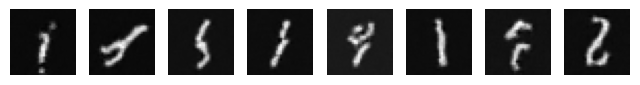

Epoch 39:   0%|          | 0/15 [00:00<?, ?it/s]

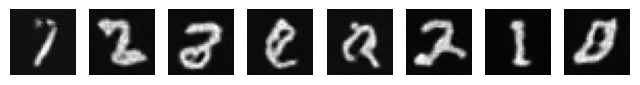

Epoch 40:   0%|          | 0/15 [00:00<?, ?it/s]

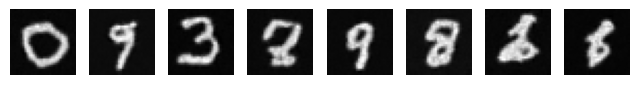

Epoch 41:   0%|          | 0/15 [00:00<?, ?it/s]

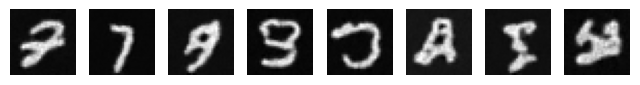

Epoch 42:   0%|          | 0/15 [00:00<?, ?it/s]

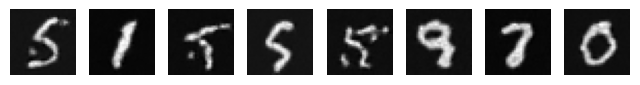

Epoch 43:   0%|          | 0/15 [00:00<?, ?it/s]

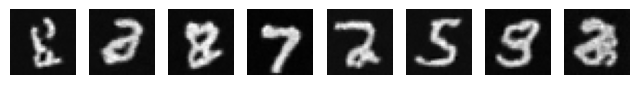

Epoch 44:   0%|          | 0/15 [00:00<?, ?it/s]

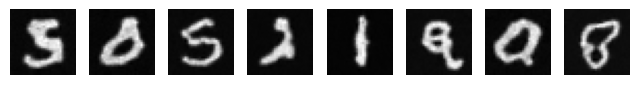

Epoch 45:   0%|          | 0/15 [00:00<?, ?it/s]

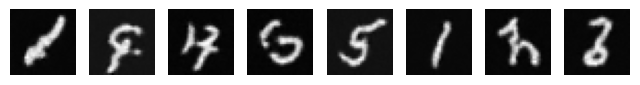

Epoch 46:   0%|          | 0/15 [00:00<?, ?it/s]

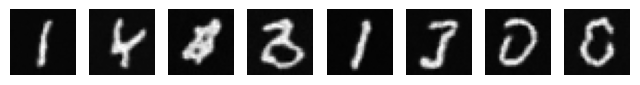

Epoch 47:   0%|          | 0/15 [00:00<?, ?it/s]

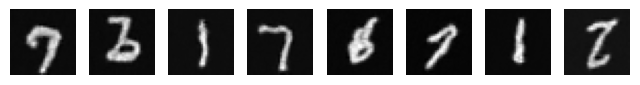

Epoch 48:   0%|          | 0/15 [00:00<?, ?it/s]

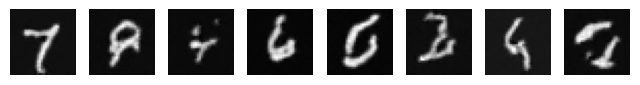

Epoch 49:   0%|          | 0/15 [00:00<?, ?it/s]

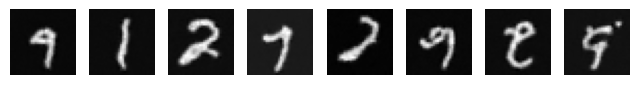

Epoch 50:   0%|          | 0/15 [00:00<?, ?it/s]

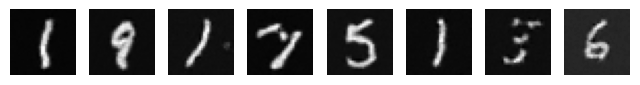

Epoch 51:   0%|          | 0/15 [00:00<?, ?it/s]

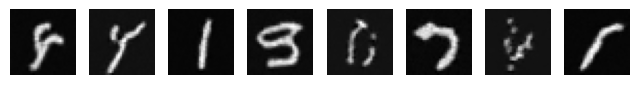

Epoch 52:   0%|          | 0/15 [00:00<?, ?it/s]

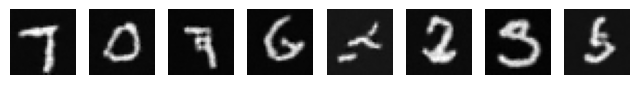

Epoch 53:   0%|          | 0/15 [00:00<?, ?it/s]

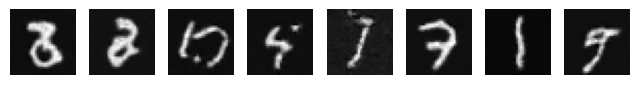

Epoch 54:   0%|          | 0/15 [00:00<?, ?it/s]

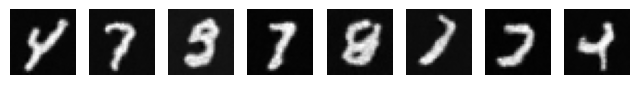

Epoch 55:   0%|          | 0/15 [00:00<?, ?it/s]

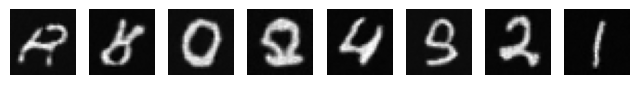

Epoch 56:   0%|          | 0/15 [00:00<?, ?it/s]

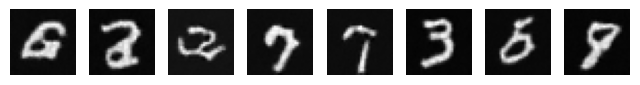

Epoch 57:   0%|          | 0/15 [00:00<?, ?it/s]

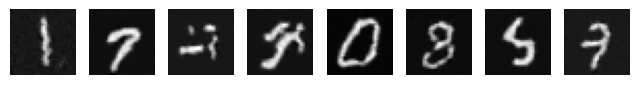

Epoch 58:   0%|          | 0/15 [00:00<?, ?it/s]

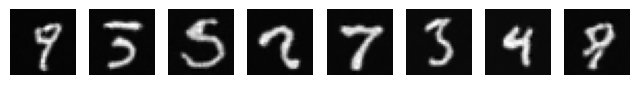

Epoch 59:   0%|          | 0/15 [00:00<?, ?it/s]

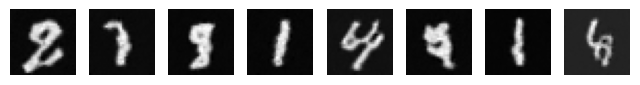

In [13]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)

        for i, t in enumerate(timesteps):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames


def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    losses = []

    for epoch in range(num_epochs):        
        # training
        model.train()
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
        for _, batch in enumerate(progress_bar):
            batch = batch[0].to(device)
            noise = torch.randn_like(batch).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],), dtype=torch.long).to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            
            # Loss function
            
            loss = F.mse_loss(noise, noise_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            progress_bar.set_postfix(loss=loss.item())
        
        progress_bar.close()
        
        # generate the image using generate_image
        generated = generate_image(model, 8, 1, 32)
        show_images(generated)
        
    return losses

learning_rate = 1e-3
num_epochs = 60
num_timesteps = 1000
network = TinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
losses = training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)
